<a href="https://colab.research.google.com/github/shreyaghotankar/CMPE-255-Data-Mining/blob/master/CMPE255_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - Implement various clustering algorithms

1. K-means
2. Hierarchical
3. Gaussian Mixture Model
4. DBScan

In [ ]:
!pip install pyyaml==5.4.1
!pip install --use-deprecated=legacy-resolver pycaret[full]

In [ ]:
import pycaret
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
# Importing Libraries
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

**Dataset - [Loan Amount Dataset from kaggle](https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset)**

## Data Cleaning

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CMPE255 - Data Mining/Assignments/Datasets/loan_dataset.csv')

In [ ]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0.0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500.0,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800.0,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546.0,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0.0,78.0,360.0,1.0,Urban


In [ ]:
df.shape

(981, 12)

In [ ]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 92.1+ KB


In [ ]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object

In [ ]:
# finding any data is missing or NaN
df.isna().sum().sort_values(ascending=False)

Credit_History       79
Self_Employed        55
LoanAmount           27
Dependents           25
Gender               24
Loan_Amount_Term     20
Married               3
Property_Area         0
CoapplicantIncome     0
ApplicantIncome       0
Education             0
Loan_ID               0
dtype: int64

In [ ]:
# replace null values with mean
df['Dependents'].fillna(value=1, inplace= True)

# replace null value with maximum occuring value
df['Gender'].fillna(df.Gender.mode().to_string(), inplace=True)

In [ ]:
# replace null with maximum occurring value
df['Self_Employed'].fillna(df.Self_Employed.mode().to_string(), inplace=True)

# replace null values with mean
df['Credit_History'].fillna(value=round(df.Credit_History.mean()), inplace=True)

# replace null with No
df['Married'].fillna(value='No', inplace= True)

In [ ]:
# replace null values with median
df['Loan_Amount_Term'].fillna(value=round(df.Loan_Amount_Term.median()), inplace=True)

In [ ]:
# replace null values with median
df['LoanAmount'].fillna(value=round(df.LoanAmount.median()), inplace=True)

In [ ]:
df.isna().sum().sort_values(ascending=False)

Property_Area        0
Credit_History       0
Loan_Amount_Term     0
LoanAmount           0
CoapplicantIncome    0
ApplicantIncome      0
Self_Employed        0
Education            0
Dependents           0
Married              0
Gender               0
Loan_ID              0
dtype: int64

In [ ]:
df.duplicated().sum()

0

**Visualization**

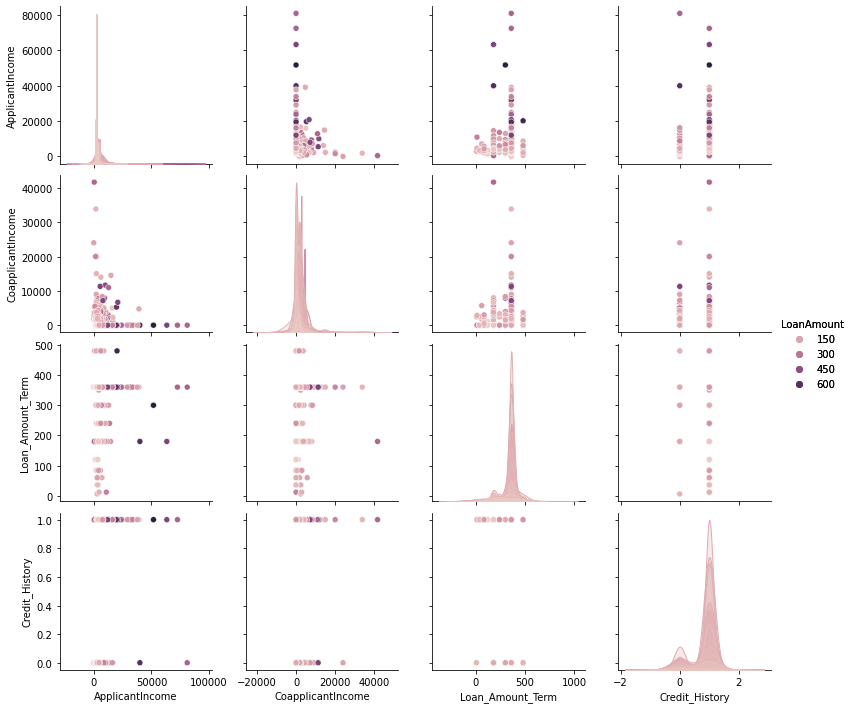

In [ ]:
sns.pairplot(df, hue='LoanAmount').add_legend()
plt.show()

## K-Means Clustering - from scratch

Steps:
1. Pick Centroids - can be random
2. Calculate Euclidean Distance between the data points
3. Based on the euclidean distance assign the data points to a centroid
4. Keep updating centroids using average of the points in each cluster
5. Repeat steps 2-4 till centroids stop changing



For clustering I am going to use the ApplicantIncome and LoanAmount columns.

In [ ]:
cols=['ApplicantIncome', 'LoanAmount']
df_subset = df[cols].copy()

df_subset.head()

,ApplicantIncome,LoanAmount
0,5720,110.0
1,3076,126.0
2,5000,208.0
3,2340,100.0
4,3276,78.0


In [ ]:
# normalize data
X = df_subset.values
ssc = StandardScaler()
X = ssc.fit_transform(X)

In [ ]:
def apply_kmeans(X,k,iternums):

  if isinstance(X, pd.DataFrame):X = X.values
  idx = np.random.choice(len(X), k, replace=False)
  centroids = X[idx, :]
  pt = np.argmin(cdist(X, centroids, 'euclidean'),axis=1)
  for _ in range(iternums):
    centroids = np.vstack([X[pt==i,:].mean(axis=0) for i in range(k)])
    tmp_centroid = np.argmin(cdist(X, centroids, 'euclidean'),axis=1)
    if np.array_equal(pt,tmp_centroid):break
    pt = tmp_centroid
  return pt

In [ ]:
labels = apply_kmeans(X,4,100)

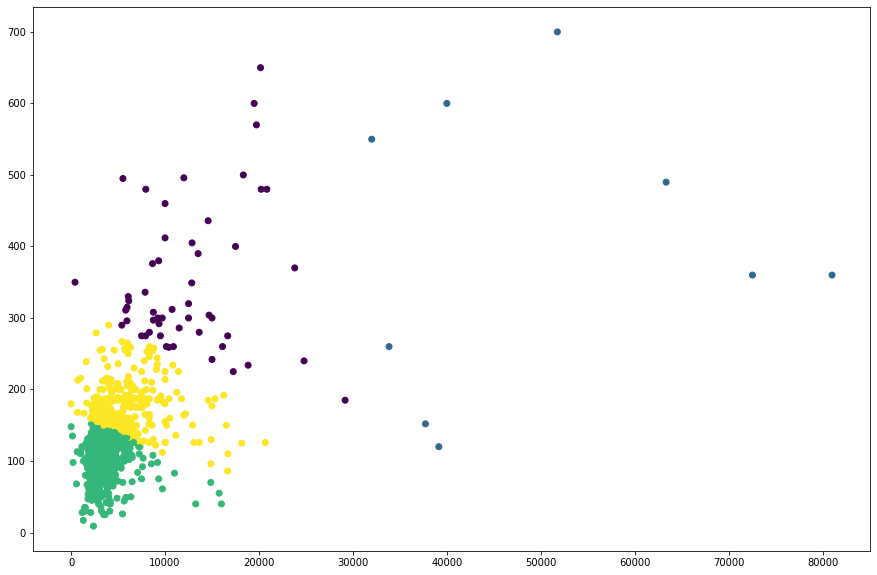

In [ ]:
X = ssc.inverse_transform(X)
plt.figure(figsize=(15,10))
plt.scatter(X[:,0],X[:,1],c=labels)
plt.show()

Trying by passing cluster value of 3

In [ ]:
labels = apply_kmeans(X,3,50)

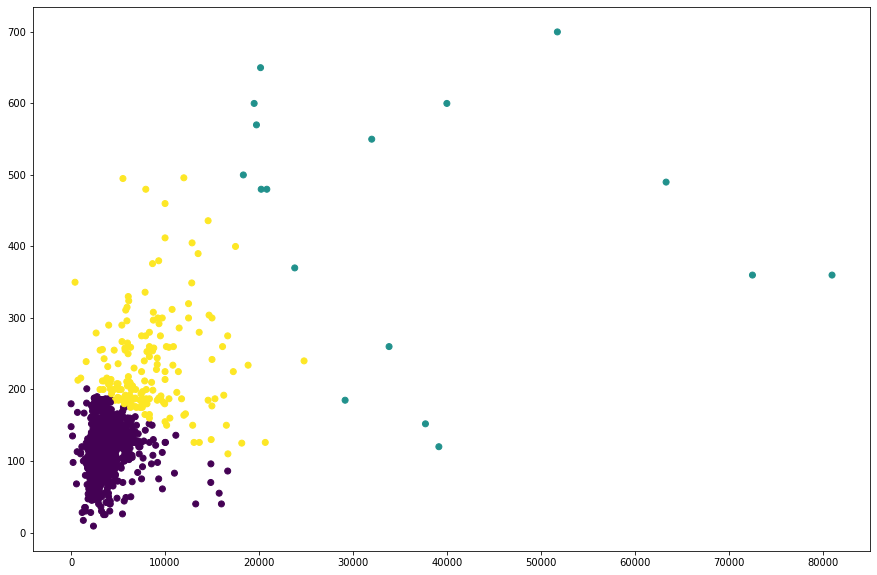

In [ ]:
X = ssc.inverse_transform(X)
plt.figure(figsize=(15,10))
plt.scatter(X[:,0],X[:,1],c=labels)
plt.show()

**Conclusion**: From the above implementations and visualization, we can say that the k=4 works better and provides better grouping of data points.

## Hierarchical Clustering

In [ ]:
x = df_subset.values

In [ ]:
# using MinMaxScaler to scale the data
mmsc = MinMaxScaler()
x = mmsc.fit_transform(x)

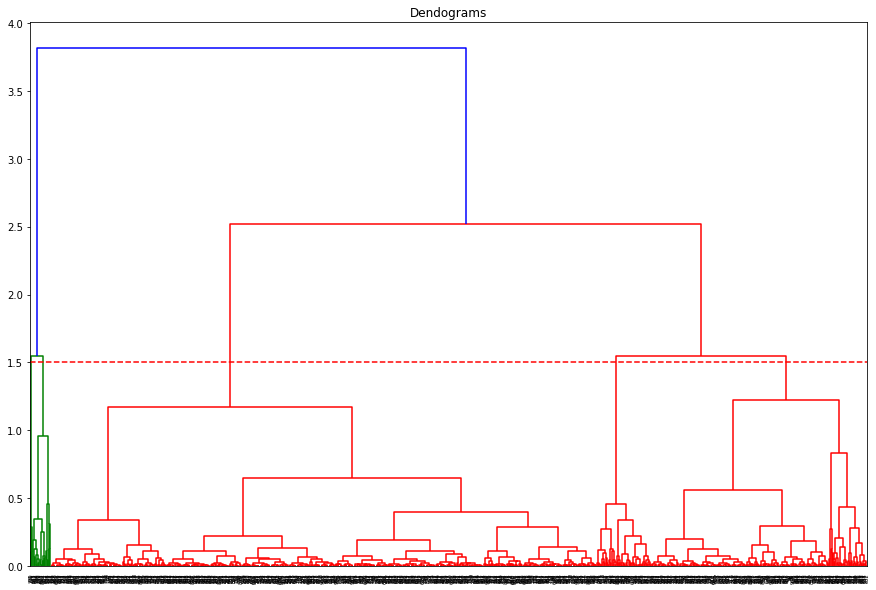

In [ ]:
# using scipy.cluster.hierarchy to generate the dendogram
plt.figure(figsize=(15, 10))
plt.title("Dendograms")
dendo = shc.dendrogram(shc.linkage(x, method='ward'))
# drawing the longest distance with the help of horizontal line
plt.axhline(y=1.5, color='r', linestyle='--')

From the above dendogram we can infer that it has 3 clusters.

In [ ]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(x)

array([2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1,
       2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1,
       2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1,
       1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 0, 1,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1,

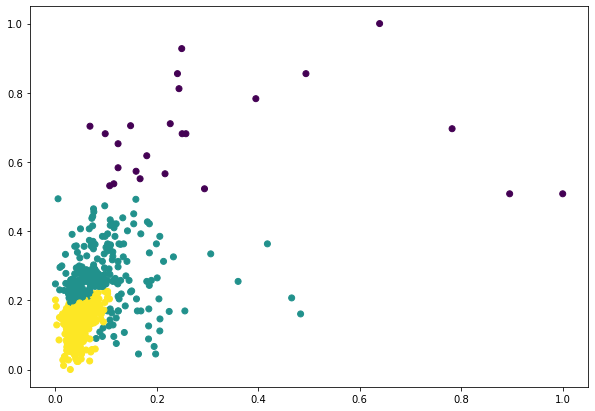

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(x[:,0], x[:,1], c=cluster.labels_, cmap='viridis')

**Conclusion**: We can clearly see the 3 clusters in the plot above. The top most is with varied loan amounts data for applicants having higher income.

## Gaussian Mixture Model

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_subset[['ApplicantIncome']])
df_subset['ApplicantIncome'] = scaler.transform(df_subset[['ApplicantIncome']])

scaler.fit(df_subset[['LoanAmount']])
df_subset['LoanAmount'] = scaler.transform(df_subset[['LoanAmount']])

df_subset.head()

,ApplicantIncome,LoanAmount
0,0.070617,0.146165
1,0.037975,0.169320
2,0.061728,0.287988
3,0.028889,0.131693
4,0.040444,0.099855


In [ ]:
# Calculate AIC and BIC
sum_bic = []
sum_aic = []

K = range(1,10)
for k in K:
    gmm = GaussianMixture(n_components=k)
    gmm = gmm.fit(df_subset)
    sum_bic.append(gmm.bic(df_subset))
    sum_aic.append(gmm.aic(df_subset))

* AIC - Akaike's Information Criteria 
* BIC - Bayesian Information Criteria

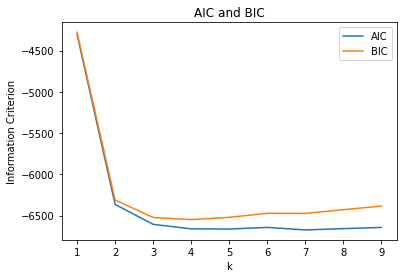

In [ ]:
# plot to visualize the AIC and BIC
x1 = K
y1 = sum_aic
plt.plot(x1, y1, label = "AIC")
x2 = K
y2 = sum_bic
plt.plot(x2, y2, label = "BIC")

plt.title("AIC and BIC")
plt.xlabel("k")
plt.ylabel("Information Criterion")
plt.legend(loc='upper right')
plt.show()

From the above plot we can work with k=3 clusters. There is a dip at 3 and then the values are not changing much.

In [ ]:
#using GaussianMixture - default covariance type is full
gmm = GaussianMixture(n_components=3, random_state=0).fit(df_subset)
labels_full = gmm.predict(df_subset)
labels_full

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

<Figure size 1080x720 with 0 Axes>

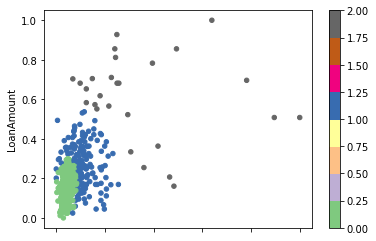

In [ ]:
plt.figure(figsize = (15,10))
df_subset.plot.scatter(x='ApplicantIncome', y='LoanAmount',c=labels_full ,s=20, cmap='Accent')

By calculating the AIC and BIC we get better information to select number clusters to perform clsutering.

## DBScan

In [ ]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0.0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500.0,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800.0,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546.0,100.0,360.0,1.0,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0.0,78.0,360.0,1.0,Urban


In [ ]:
cols=['ApplicantIncome', 'LoanAmount']
df_subset = df[cols].copy()

df_subset.head()

,ApplicantIncome,LoanAmount
0,5720,110.0
1,3076,126.0
2,5000,208.0
3,2340,100.0
4,3276,78.0


### Using sklearn

In [ ]:
ssc = StandardScaler()
X = ssc.fit_transform(df_subset)

In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

<Figure size 1080x720 with 0 Axes>

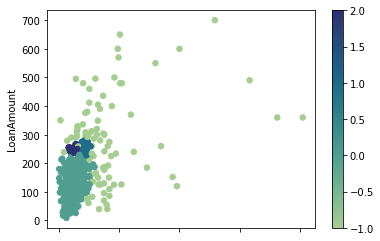

In [ ]:
plt.figure(figsize = (15,10))
df_subset.plot.scatter(x='ApplicantIncome', y='LoanAmount',c=labels ,s=30, cmap='crest')

From the above plot we can clearly see 4 clusters. The 2 small clusters are very close to each other almost overlapping.

From all the clustering methods, we have got similar results and can confidently say that for this dataset K=3 clusters suits the best.

### Using pycaret

In [ ]:
from pycaret.clustering import *

In [ ]:
clus = setup(df_subset, log_experiment=True, log_plots=True)

,Description,Value
0,session_id,2236
1,Original Data,"(981, 2)"
2,Missing Values,False
3,Numeric Features,2
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(981, 2)"
9,CPU Jobs,-1


In [ ]:
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [ ]:
dbscan = create_model('dbscan')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0,0,0,0,0,0


<Figure size 576x396 with 0 Axes>

In [ ]:
print(dbscan)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=-1, p=None)


In [ ]:
dbscan = create_model('dbscan', eps=0.3, min_samples=10) # changed the default eps adn min_samples values

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0,0,0,0,0,0


<Figure size 576x396 with 0 Axes>

In [ ]:
dbscan_results = assign_model(dbscan)
dbscan_results.head()

,ApplicantIncome,LoanAmount,Cluster
0,5720,110.0,Cluster -1
1,3076,126.0,Cluster -1
2,5000,208.0,Cluster -1
3,2340,100.0,Cluster -1
4,3276,78.0,Cluster -1


In [ ]:
plot_model(dbscan)

The above implementation did not create multiple clusters.

Performing DBScan clustering again and including normalize parameter to see if any difference is there.

In [ ]:
clus = setup(df_subset, normalize=True, log_experiment=True, log_plots=True)

,Description,Value
0,session_id,5396
1,Original Data,"(981, 2)"
2,Missing Values,False
3,Numeric Features,2
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(981, 2)"
9,CPU Jobs,-1


Creating 2 instances of the model with different parameters to see if silouette score changes.

In [ ]:
dbscan1 = create_model('dbscan')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7984,700.4219,0.776,0,0,0


<Figure size 576x396 with 0 Axes>

In [ ]:
dbscan2 = create_model('dbscan', eps=0.3, min_samples=10)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4439,233.3547,1.4747,0,0,0


<Figure size 576x396 with 0 Axes>

Plotting both the models to see the clusters

In [ ]:
plot_model(dbscan1)

In the above plot we can clearly see 2 clusters are formed. Cluster in red has maximum data points and blue color cluster has data points far away which can be used to determine the outliers.

In [ ]:
plot_model(dbscan2)

In the above plot we can clearly see 3 clusters being formed. Cluster in red is still same as in the previous dbscan implementation. But it has a small cluster 2 in green and the remaining are all associated with cluster 3 in blue color.



---



---



---



---



# References
1. https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset
2. https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
3. https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN
5. http://www.pycaret.org/tutorials/html/CLU101.html
